In [58]:
import pandas as pd
import plotly.graph_objects as go
from collections import defaultdict
from s2sphere import CellId, LatLng, Cell

In [59]:
# http://s2geometry.io/about/overview
# http://s2geometry.io/devguide/s2cell_hierarchy.html
def adaptive_partition(df: pd.DataFrame, t1: int = 10_000, t2: int = 50, max_level: int = 18):
    all_cells = defaultdict(list)
    
    # Loop through all lat,lon values
    for _, row in df.iterrows():
        lat, lon = row['lat'], row['lon']
        latlng = LatLng.from_degrees(lat, lon)
        cell_id = CellId.from_lat_lng(latlng)
        
        # Add the lat,lon to be cells at each hierarchy
        for level in range(max_level + 1):
            parent = cell_id.parent(level)
            all_cells[parent.id()].append((lat, lon))
            
    final_cells = set()
    processed = set()
    
    def recurse(cell_id_val: CellId, depth: int):
        """Recursive function to calculate and slice cells of the grid"""
        # Cell already processed
        if cell_id_val in processed:
            return
        processed.add(cell_id_val)
        
        points_list = all_cells.get(cell_id_val, [])
        # No points exist in the cell
        if len(points_list) == 0:
            return
            
        # Not big enough to split or done splitting
        if len(points_list) <= t1 or depth >= max_level:
            # Only keep cells that contain enough points
            if len(points_list) >= t2:
                final_cells.add(cell_id_val)
            return
        
        # Too many points, recurse through each split of the cell
        cell_id_obj = CellId(cell_id_val)
        for i in range(4):
            child = cell_id_obj.child(i)
            recurse(child.id(), depth + 1)
    
    # Iterate through each level and recurve through the cells
    for level in range(max_level + 1):
        level_cells = [cid for cid in all_cells.keys() if CellId(cid).level() == level]
        for cell_id_val in level_cells:
            if cell_id_val not in processed:
                recurse(cell_id_val, level)
    
    return final_cells

def get_cell_vertices(cell_id_val: CellId):
    """Grabs all 4 vertices of a cell"""
    cell_id_obj = CellId(cell_id_val)
    cell = Cell(cell_id_obj)
    vertices = []
    for i in range(4):
        vertex = cell.get_vertex(i)
        latlng = LatLng.from_point(vertex)
        vertices.append((latlng.lat().degrees, latlng.lng().degrees))
    return vertices

In [60]:
sampled_df = pd.read_csv('../data/imgs/sampled.csv', index_col=0)
if 'lat' in sampled_df.columns and 'lon' in sampled_df.columns:
    sampled_df = sampled_df.drop(columns=['lat', 'lon'])
points_df = pd.read_csv('../data/points.csv')
points_df = points_df.rename(columns={'id': 'orig_id'})
points_df = points_df[['orig_id', 'lat', 'lon']]
city_df = pd.merge(sampled_df, points_df, on=['orig_id'])
print("Data shape:", city_df.shape)
display(city_df.head())

Data shape: (177610, 10)


,uuid,source,orig_id,city,country,iso3,s2_cell_id,label,lat,lon
0,99891cd8-bd32-4cc9-9e48-9d7fbdc30909,Mapillary,755195782374799,Washington,United States,USA,9.923602e+18,6,38.892015,-77.031205
1,0752026e-3449-4e9a-a75b-974e16738eca,Mapillary,3983548141753049,Washington,United States,USA,9.923602e+18,7,38.903943,-77.018739
2,7e2600a1-eaaf-4d91-8d4d-065984e90cde,Mapillary,233657401861198,Washington,United States,USA,9.923602e+18,4,38.899477,-77.031631
3,2e92aa72-215d-4672-aa1f-bcd71b02322d,Mapillary,958812788229569,Washington,United States,USA,9.923602e+18,5,38.902491,-77.029299
4,e9e94c21-5d7b-4f4d-9fb0-42c71745b376,Mapillary,287795916343455,Washington,United States,USA,9.923602e+18,3,38.893817,-77.015253


In [75]:
# t1=5_000, t2=50, max_level=30 for 1,000,000 looks pretty good
# Level 0: 6 cells
# Level 1: 24 cells
# ...
# Total cells = 6 * 4^level
max_level = 30
final_cells = adaptive_partition(city_df, t1=10000, t2=2000, max_level=max_level)

In [62]:
def latlon_to_cellid(lat: float, lon: float):
    """Find which final cell this lat/lon belongs to"""
    latlng = LatLng.from_degrees(lat, lon)
    cell_id = CellId.from_lat_lng(latlng)
    
    # Traverse from max_level down to find the corresponding cell
    # Each lat,lon only belongs to the highest level cell
    for level in range(max_level, -1, -1):
        parent = cell_id.parent(level)
        parent_id = parent.id()
        
        if parent_id in final_cells:
            return parent_id
    
    return None

# Add the cell id corresponding to each latitude and longitude
city_df['s2_cell_id'] = city_df.apply(
    lambda row: latlon_to_cellid(row['lat'], row['lon']), 
    axis=1
)

# Remove null cell_ids
city_df.dropna(subset=['s2_cell_id'], inplace=True)
cell_ids = [int(id) for id in set(city_df['s2_cell_id'].unique())]
print(f"Number of unique cells: {len(cell_ids)}")

Number of unique cells: 132


In [76]:
def visualize_s2_cells(final_cells: set[CellId]):
    fig = go.Figure()
    
    for cell_id_val in final_cells:
        vertices = get_cell_vertices(cell_id_val)
        lats = [v[0] for v in vertices] + [vertices[0][0]]
        lons = [v[1] for v in vertices] + [vertices[0][1]]
        
        fig.add_trace(go.Scattergeo(
            lon=lons,
            lat=lats,
            mode='lines',
            line=dict(width=1, color='blue'),
            showlegend=False
        ))
    
    fig.update_layout(
        title=f'Adaptive S2 Cell Partitioning - {len(final_cells)} Cells',
        geo=dict(
            projection_type='natural earth',
            showland=True,
            showcountries=True,
        ),
        height=720,
        width=1280,
    )
    return fig

fig = visualize_s2_cells(cell_ids)
fig.show()

In [77]:
# Create the labels as a sequence from 0 to num_unique_cells
replacement_dict = dict()
for i, cell_id in enumerate(cell_ids):
    replacement_dict[cell_id] = i
    
city_df['label'] = city_df['s2_cell_id'].replace(replacement_dict).astype(int)
city_df.to_csv('../data/imgs/sampled.csv')
print(f"Number of unique cells: {len(city_df['s2_cell_id'].unique())}")
print(city_df['label'].unique())

Number of unique cells: 132
[  9  10   7   8   6  11  12  16  17  18  25  49  50  51  52  53  54  55
  56  57  68  36  82 130 128  83  13 121 109  69  23  24 127  37  14 115
  94  74 119  81  30  15 113 120  58  40 131 100  22  19  20   3  41  42
  43  77  44 101 103  45  46 105   4  47   5 102 104 107  99  21  84  48
  78  39 106 108  65  32  98  59 114  90  33  66 124 125  26  79  76 117
  95  27  60 111  75   0  34  73  85  92  35  31  70  80  97  61 122  28
  86  62  38  29  96  87  63 129 110 118  64 126  71  93 116 123   1  72
  67 112  88  91   2  89]


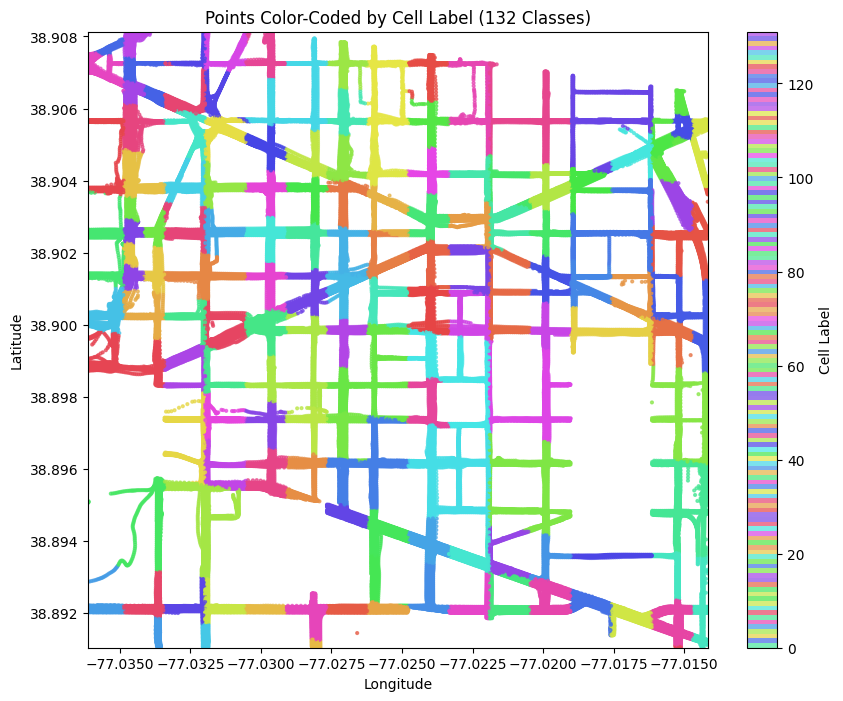

In [78]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

def scatter_points_by_label(city_df: pd.DataFrame):
    plt.figure(figsize=(10, 8))
    num_labels = city_df['label'].nunique()
    
    # Generate unique colors for each label using HSV color space
    hues = np.linspace(0, 1, num_labels, endpoint=False)
    np.random.seed(42)
    np.random.shuffle(hues)  # Shuffle to avoid similar colors being adjacent
    colors = [mcolors.hsv_to_rgb([h, 0.7, 0.9]) for h in hues]
    cmap = mcolors.ListedColormap(colors)
    
    scatter = plt.scatter(
        city_df['lon'], city_df['lat'],
        c=city_df['label'], cmap=cmap, s=4, alpha=0.7
    )
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title(f'Points Color-Coded by Cell Label ({num_labels} Classes)')
    plt.xlim(city_df['lon'].min(), city_df['lon'].max())
    plt.ylim(city_df['lat'].min(), city_df['lat'].max())
    plt.colorbar(scatter, label='Cell Label')
    plt.show()

scatter_points_by_label(city_df)

In [79]:
# Output cell IDs ordered by the count of points in each cell
cell_counts = city_df.groupby('s2_cell_id').size().reset_index(name='count')
cell_counts_sorted = cell_counts.sort_values(by='count', ascending=False)
print(cell_counts_sorted)

              s2_cell_id  count
29   9923602134111092736   3010
28   9923602131963609088   2838
79   9923602168470831104   2674
35   9923602140553543680   2491
27   9923602125521158144   2379
..                   ...    ...
81   9923602170618314752    500
86   9923602177060765696    500
5    9923602089013936128    444
111  9923602340269522944    398
9    9923602094382645248     28

[132 rows x 2 columns]


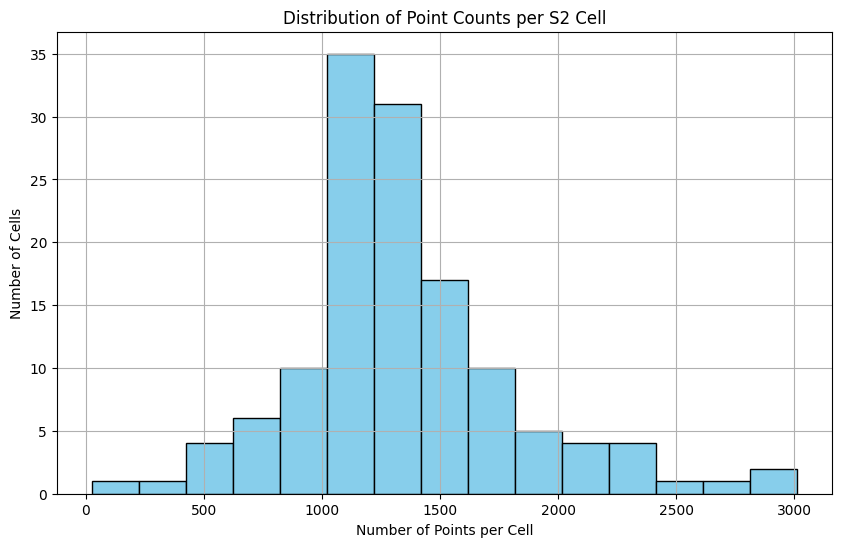

In [82]:
import matplotlib.pyplot as plt

# Plot the distribution of point counts per cell
plt.figure(figsize=(10, 6))
plt.hist(cell_counts_sorted['count'], bins=15, color='skyblue', edgecolor='black')
plt.xlabel('Number of Points per Cell')
plt.ylabel('Number of Cells')
plt.title('Distribution of Point Counts per S2 Cell')
plt.grid(True)
plt.show()